In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_absolute_error,
)


import seaborn as sns
import matplotlib.pyplot as plt


In [17]:
class CustRNN(nn.Module):
    def __init__(self, input_shape, output_shape, n_dense_1, n_dense_2):
        super(CustRNN, self).__init__()
        self.rnn_layer = nn.RNN(input_size=input_shape,hidden_size=10,num_layers=3, nonlinearity='relu')
        self.layer_1 =  nn.Linear(10, n_dense_1)
        self.bn1 = nn.BatchNorm1d(num_features=n_dense_1)
        self.layer_2 =  nn.Linear(n_dense_1, n_dense_2)
        self.layer_3 =  nn.Linear(n_dense_2, output_shape, dtype= torch.float32)
        
        
    def forward(self, input, hidden_prev):
        x, hidden_nxt = self.rnn_layer(input,hidden_prev)
        # print(x.shape)
        x = F.relu(self.layer_1(x))
        # if x.dim()>1:
        #     x = self.bn1(x)
        x = F.relu(self.layer_2(x))
        outputs = self.layer_3(x)
        return outputs, hidden_nxt

In [19]:
training_data = pd.read_csv('../train_df_2.csv')
training_data = training_data.drop(['Unnamed: 0'], axis=1)

target_data = training_data[['RV0']]
feature_data = training_data[[f'RV{i}' for i in range(28,100 + 1)]]

In [133]:
target_data_tensor = torch.tensor(target_data.to_numpy(), dtype= torch.float32)
feature_data_tensor = torch.tensor(feature_data.to_numpy(), dtype= torch.float32)

In [140]:
rnn_model = CustRNN( input_shape=73, output_shape=1, n_dense_1=100, n_dense_2=100)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)

hidden_prev = torch.randn(3, 10)
for epoch in range(1000):
    pred,hidden_prev = rnn_model(feature_data_tensor,hidden_prev)
    hidden_prev = hidden_prev.detach()
    
    cost = nn.functional.mse_loss(pred,target_data_tensor)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    if epoch % 100==0:
        print('epoch:',epoch,' cost:',cost)



epoch: 0  cost: tensor(17177138., grad_fn=<MseLossBackward0>)
epoch: 100  cost: tensor(1188309.6250, grad_fn=<MseLossBackward0>)
epoch: 200  cost: tensor(664212.5625, grad_fn=<MseLossBackward0>)
epoch: 300  cost: tensor(560970.1875, grad_fn=<MseLossBackward0>)
epoch: 400  cost: tensor(501198.8750, grad_fn=<MseLossBackward0>)
epoch: 500  cost: tensor(450515.0938, grad_fn=<MseLossBackward0>)
epoch: 600  cost: tensor(415199.6250, grad_fn=<MseLossBackward0>)
epoch: 700  cost: tensor(379943.0312, grad_fn=<MseLossBackward0>)
epoch: 800  cost: tensor(352542.8438, grad_fn=<MseLossBackward0>)
epoch: 900  cost: tensor(322850.7812, grad_fn=<MseLossBackward0>)


In [20]:
test_df = pd.read_csv('../test_df_2.csv').reset_index(drop=True).drop('Unnamed: 0',axis=1)
test_df['arrival_date'] = pd.to_datetime(test_df['arrival_date'])

In [141]:
pred_dct = {'arrival_date':[], f'RV0':[], 'pred':[]}

for i in range(len(test_df)):
    actual_value =test_df.iloc[i]['RV0']
    feature_values = test_df.iloc[i][feature_data.columns].to_numpy(dtype='float32').reshape((1,-1))

    pred, hidden_prev = rnn_model(torch.tensor(feature_values, dtype=torch.float32),  hidden_prev)
    hidden_prev = hidden_prev.detach()
    pred = pred.detach().numpy()

    pred_dct['arrival_date'].append(test_df.iloc[i]['arrival_date'])
    pred_dct[f'RV0'].append(actual_value)
    pred_dct['pred'].append(pred[0][0])

pred_df = pd.DataFrame(pred_dct)
pred_df['arrival_date'] = pd.to_datetime(pred_df['arrival_date'])

In [142]:
TARGET =f'RV0'


print('SMAPE:',mean_absolute_percentage_error(y_pred=pred_df['pred'], y_true=pred_df[TARGET], symmetric=True))
print('MAE:',mean_absolute_error(y_pred=pred_df['pred'], y_true=pred_df[TARGET]))


display_cols =['arrival_date', TARGET, 'pred']+feature_data.columns.to_list()
merged_df = pred_df.merge(test_df.drop(TARGET, axis=1), on='arrival_date',how='inner')[display_cols]
merged_df

SMAPE: 0.26079875463141067
MAE: 763.0975505712851


,arrival_date,RV0,pred,RV28,RV29,RV30,RV31,RV32,RV33,RV34,...,RV91,RV92,RV93,RV94,RV95,RV96,RV97,RV98,RV99,RV100
0,2016-09-01,6255.86,6324.323242,4397.88,4397.88,4397.88,4397.88,4397.88,4397.88,4397.88,...,3845.55,3845.55,3845.55,3845.55,3845.55,3845.55,3845.55,3845.55,3845.55,3845.55
1,2016-09-02,4366.89,3844.747559,2398.77,2398.77,2398.77,2398.77,2398.77,2398.77,2398.77,...,2133.77,2133.77,2133.77,2133.77,2133.77,2133.77,2133.77,2133.77,2133.77,2133.77
2,2016-09-03,5232.95,5305.280273,3532.35,3532.35,3532.35,3532.35,3532.35,3532.35,3532.35,...,2473.75,2473.75,2473.75,2473.75,2473.75,2473.75,2473.75,2473.75,2473.75,2473.75
3,2016-09-04,3275.52,3793.620605,2163.82,2163.82,2163.82,2163.82,2163.82,2163.82,2163.82,...,2163.82,2163.82,2163.82,2163.82,1964.82,1964.82,1964.82,1964.82,1964.82,1964.82
4,2016-09-05,5278.86,5510.555664,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,...,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83,3658.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2017-08-27,9816.47,10323.423828,7250.13,7046.13,7046.13,7046.13,7046.13,7046.13,6792.88,...,4129.59,4129.59,4129.59,4129.59,4129.59,3945.30,3945.30,3552.30,3552.30,3552.30
361,2017-08-28,8957.56,9123.855469,6434.68,5896.68,5896.68,5896.68,5699.93,5699.93,5699.93,...,3255.63,3255.63,3255.63,3255.63,3255.63,3079.38,3079.38,3079.38,3079.38,3079.38
362,2017-08-29,3512.50,5249.246582,2326.22,2326.22,2326.22,1982.71,1982.71,1982.71,1982.71,...,1231.63,1231.63,1231.63,1231.63,1231.63,1231.63,1231.63,1231.63,1231.63,1231.63
363,2017-08-30,4837.43,4970.214844,1641.10,1641.10,1641.10,1641.10,1641.10,1641.10,1641.10,...,868.97,868.97,868.97,868.97,868.97,868.97,868.97,868.97,868.97,868.97


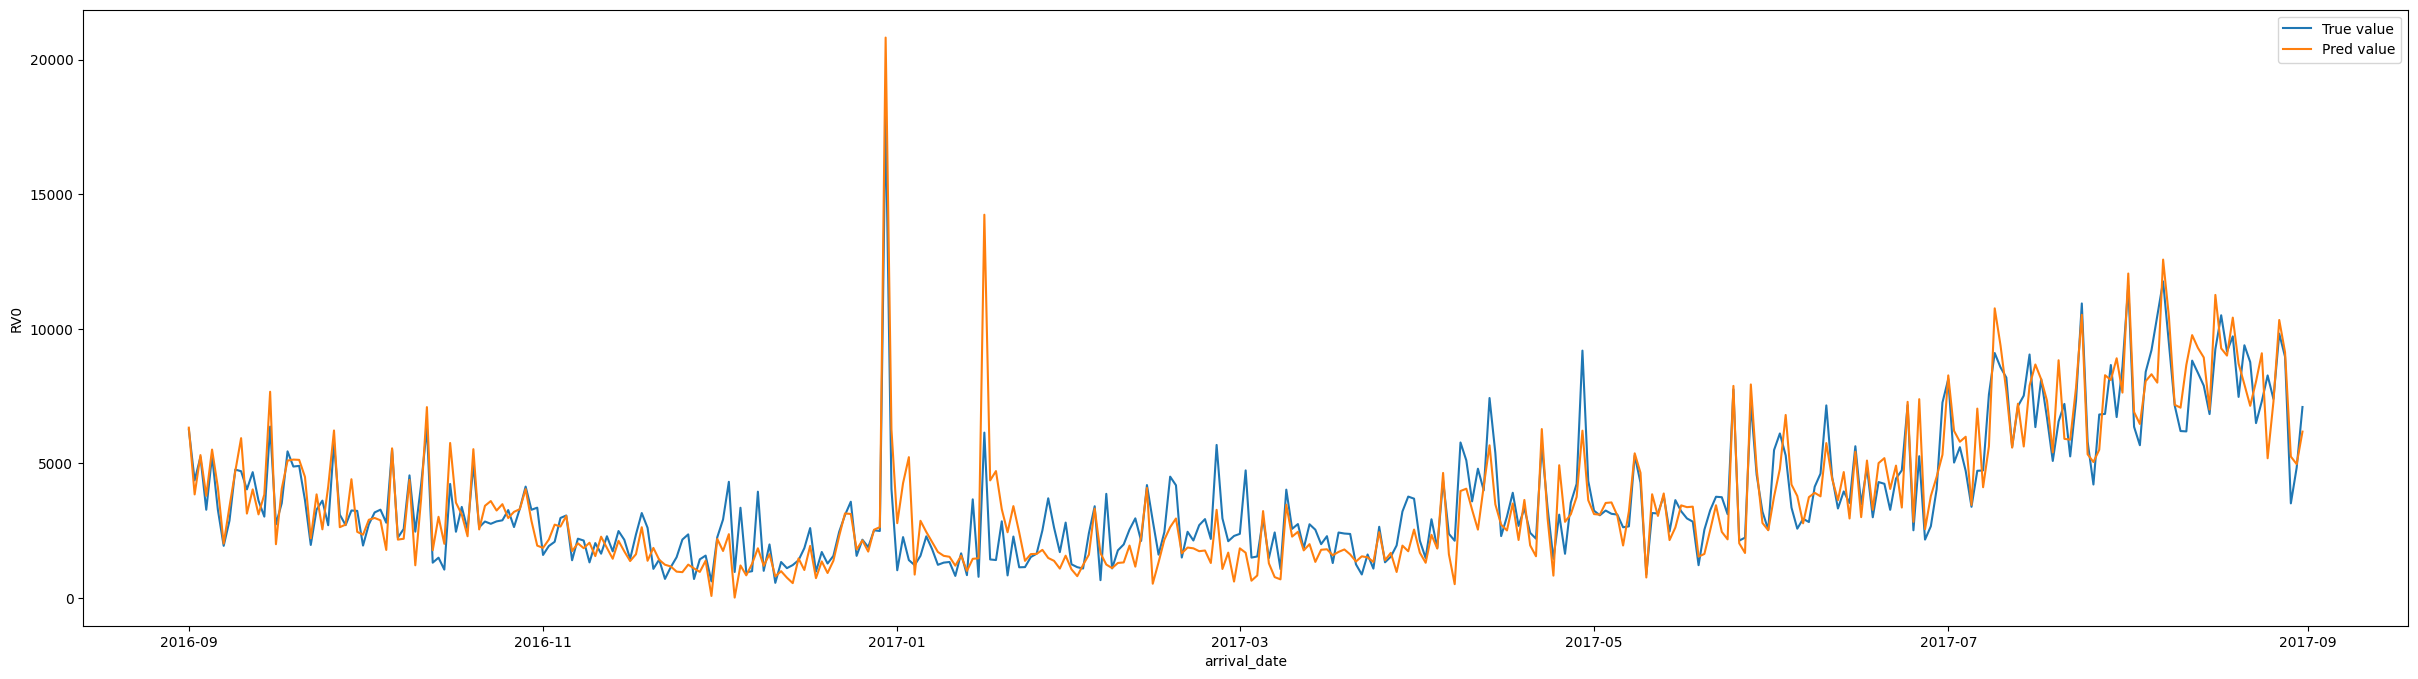

In [143]:
plt.figure(figsize=(30,8))
sns.lineplot(data=pred_df, x = 'arrival_date', y=TARGET, label='True value')
sns.lineplot(data=pred_df, x = 'arrival_date', y='pred', label='Pred value')
plt.legend()